In [14]:
import csv


WBC_PATH = 'WBC.csv'
FEVER_PATH = 'fever.csv'
DIAGNOSIS_FIELD = 'Diagnosis'
WBC_FIELD = 'WBC'
FEVER_FIELD = 'High Temperature'

PY3 = 'Py3'
PY2 = 'Py2.7'
NO = 'No'
POP = 'Healthy'

def open_dataset(path, data_field, data_type):
    data = {}
    with open(path, 'rb') as data_file:
        reader = csv.DictReader(data_file)
        for row in reader:
            diag = row[DIAGNOSIS_FIELD]
            if diag == NO:
                diag = POP
                
            value = data_type(row[data_field])
            if diag not in data:
                data[diag] = []
                
            data[diag].append(value)
            
    return data

wbc_data = open_dataset(WBC_PATH, WBC_FIELD, int)
fever_data = open_dataset(FEVER_PATH, FEVER_FIELD, float)
        

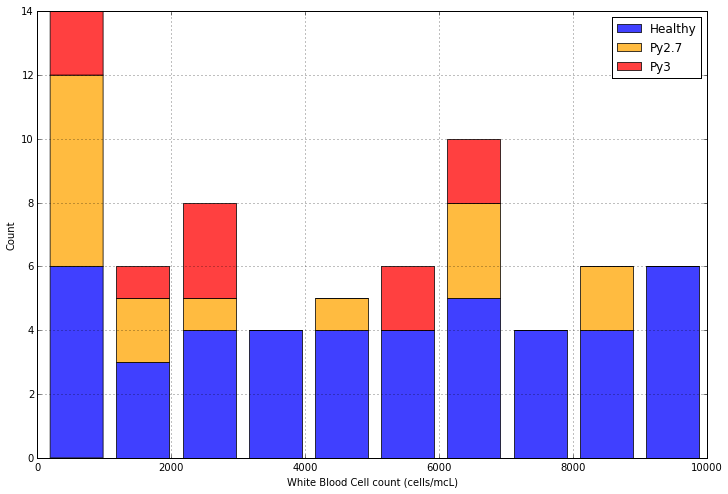

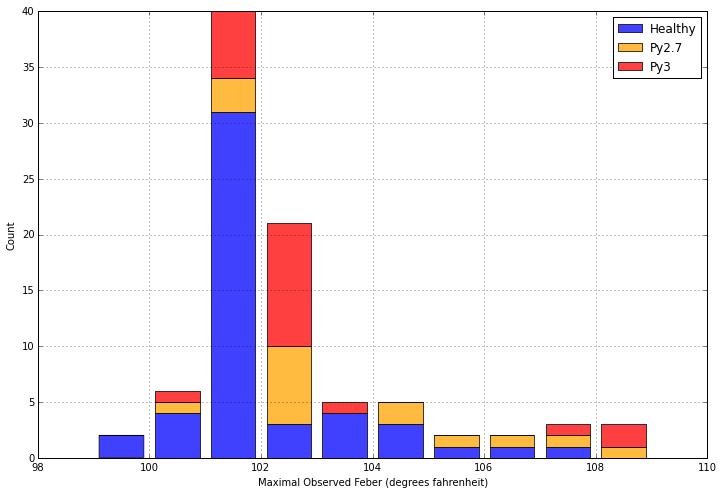

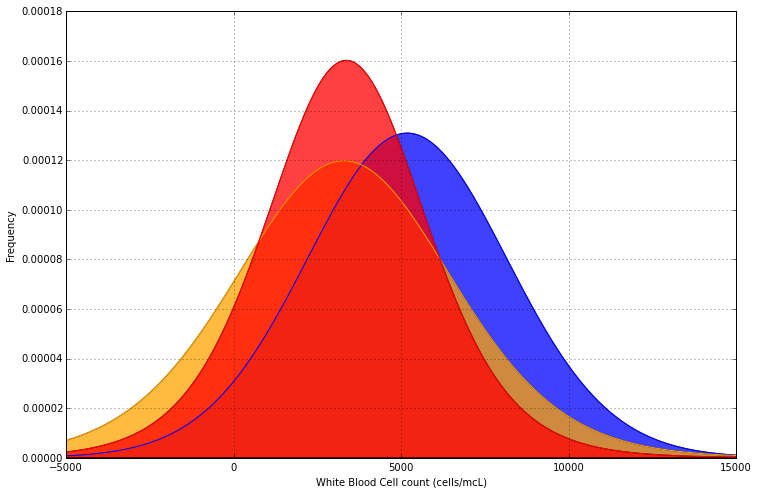

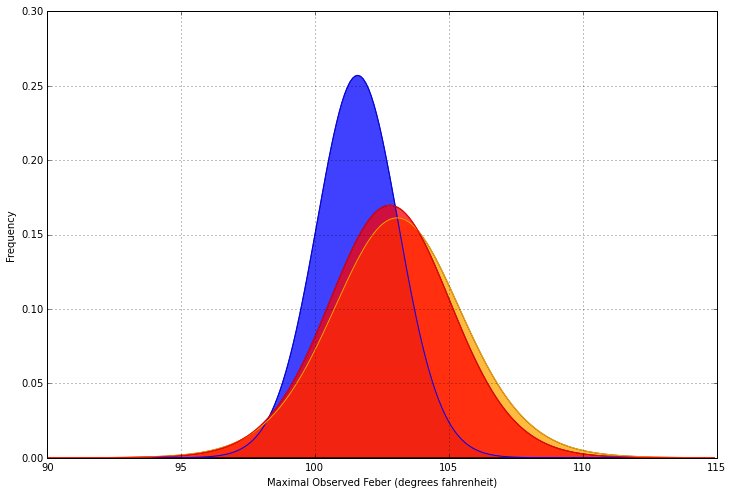

In [61]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline


DEFAULT_HORIZONTAL_SIZE = 12
DEFAULT_VERTICAL_SIZE = 8
DEFAULT_DPI = 800
COLORS = ('blue', 'orange', 'red')
FIELD_ORDER = (POP, PY2, PY3)


def get_datasets(data):
    return [data[field] for field in FIELD_ORDER]


def histogram(data, name):
    plot.figure(figsize=(DEFAULT_HORIZONTAL_SIZE, DEFAULT_VERTICAL_SIZE), 
                dpi=DEFAULT_DPI)
    plot.hist(get_datasets(data), histtype='barstacked', color=COLORS, alpha=0.75)
    
    plot.legend(FIELD_ORDER, loc='best')
    plot.xlabel(name)
    plot.ylabel('Count')
    plot.grid(True)
    plot.show()
    
    
def t_distributions(data, name, x_min, x_max, x_step):
    plot.figure(figsize=(DEFAULT_HORIZONTAL_SIZE, DEFAULT_VERTICAL_SIZE), 
                dpi=DEFAULT_DPI)
    
    x_values = np.arange(x_min, x_max, x_step)
    data_sets = get_datasets(data)
    
    for i in xrange(len(data_sets)):
        data_set = data_sets[i]
        mean, std, se, n = sample_stats(data_set)
        y_values = stats.t.pdf(x_values, n - 1, mean, std)
        color = COLORS[i]
        plot.plot(x_values, y_values, color=color)
        plot.fill_between(x_values, 0, y_values, facecolor=color, alpha=0.75)
    
    plot.legend(loc='best')
    plot.xlabel(name)
    plot.ylabel('Frequency')
    plot.grid(True)
    plot.show()

    
histogram(wbc_data, 'White Blood Cell count (cells/mcL)')
histogram(fever_data, 'Maximal Observed Feber (degrees fahrenheit)')

t_distributions(wbc_data, 'White Blood Cell count (cells/mcL)', -5000, 15000, 10)
t_distributions(fever_data, 'Maximal Observed Feber (degrees fahrenheit)', 90, 115, 0.1)

In [67]:
from scipy import stats
import numpy as np
import itertools


DEFAULT_ALPHA = 0.95


def sample_stats(sample):
    mean = np.mean(sample)
    # ddof = 1 gives the n-1 for Bessel's correction
    std = np.std(sample, ddof=1)
    n = len(sample)
    se = std / (n ** 0.5)
    return mean, std, se, n
    

def desc_and_ci(sample, alphas=(DEFAULT_ALPHA,)):
    mean, std, se, n = sample_stats(sample)
    intervals = [stats.t.interval(alpha, n - 1, mean, se) 
                 for alpha in alphas]
    print mean, std, se
    print intervals

    
def print_all_descs():
    for data_set in (wbc_data, fever_data):
        for field in FIELD_ORDER:
            print field
            desc_and_ci(data_set[field], (0.8, 0.95))
        print

    
def two_sample_stats(first_sample, second_sample):
    first_mean, first_std, first_se, first_n = sample_stats(first_sample)
    second_mean, second_std, second_se, second_n = sample_stats(second_sample)

    mean_diff = max(first_mean, second_mean) - min(first_mean, second_mean)
    se_diff = (first_se ** 2 + second_se ** 2) ** 0.5
    diff_t_score = mean_diff / se_diff
    diff_df = min(len(first_sample), len(second_sample)) - 1
    
    pooled_sd = ( ( (first_n - 1) * first_std ** 2 + 
                   (second_n - 1) * second_std ** 2 ) 
                 / (first_n + second_n - 2) ) ** 0.5

    return mean_diff, se_diff, diff_t_score, diff_df, pooled_sd
    
    
def diff_of_means_t_test(first_sample, second_sample, sides=1):
    mean_diff, se_diff, diff_t_score, diff_df, pooled_sd = \
        two_sample_stats(first_sample, second_sample)
    diff_p_value = stats.t.sf(diff_t_score, diff_df) * sides    
    return mean_diff, se_diff, diff_t_score, diff_p_value


def effect_size(first_sample, second_sample):
    mean_diff, se_diff, diff_t_score, diff_df, pooled_sd = \
        two_sample_stats(first_sample, second_sample)
        
    cohens_d = mean_diff / pooled_sd
    hedges_g = cohens_d * (1 - 
        (3.0 / (4 * (len(first_sample) + len(second_sample)) - 9)))
    return cohens_d, hedges_g


def print_t_tests_and_effect_sizes():
    print 'x\tse\tt\tp\td\tg'
    for data_set in (wbc_data, fever_data):
        for first_field, second_field in itertools.combinations(FIELD_ORDER, 2):
            if first_field == POP or second_field == POP:
                sides = 1
            else:
                sides = 2
            
            first_data = data_set[first_field]
            second_data = data_set[second_field]
            mean, se, t_value, p_value = \
                diff_of_means_t_test(first_data, second_data, sides)
            cohens_d, hedges_g = effect_size(first_data, second_data)
            print '{x:.3f}\t{se:.3f}\t{t:.3f}\t{p:.3f}\t{d:.3f}\t{g:.3f}'.format(x=mean,
                se=se, t=t_value, p=p_value, d=cohens_d, g=hedges_g)
            
        print 


print_all_descs()
print_t_tests_and_effect_sizes()

Healthy
5175.68181818 3029.29281618 456.683075063
[(4581.2852278420605, 5770.0784085215755), (4254.6926255042526, 6096.6710108593834)]
Py2.7
3284.93333333 3272.018675 844.831589116
[(2148.6091846735335, 4421.2574819931333), (1472.9497874656483, 5096.9168792010187)]
Py3
3358.0 2421.38036849 765.707704603
[(2299.0042393219928, 4416.9957606780072), (1625.8488314656311, 5090.1511685343685)]

Healthy
101.59 1.54421236776 0.218384607367
[(101.30630337355269, 101.87369662644731), (101.1511397014423, 102.0288602985577)]
Py2.7
103.058823529 2.43594407354 0.590803218429
[(102.26906309269619, 103.84858396612735), (101.80637665586639, 104.31127040295715)]
Py3
102.795454545 2.32306801916 0.495279765828
[(102.14010636514045, 103.45080272576864), (101.76546388742564, 103.82544520348345)]

x	se	t	p	d	g
1890.748	960.364	1.969	0.035	0.612	0.604
1817.682	891.554	2.039	0.036	0.620	0.611
73.067	1140.197	0.064	0.950	0.025	0.024

1.469	0.630	2.332	0.017	0.814	0.804
1.205	0.541	2.227	0.019	0.665	0.658
0.263	0

In [46]:
CUTOFF_TEMP = 102 # degrees F

def cutoff_values(data_set, cutoff):
    count_below = len([x for x in data_set if x <= cutoff])
    total = len(data_set)
    return total, count_below, total - count_below


def p_above_cutoff(data_set, cutoff):
    # under the assumption that using Student's t is valid
    mean, std, se, n = sample_stats(data_set)  
    return stats.t.sf(cutoff, n - 1, mean, std)


for field in FIELD_ORDER:
    print cutoff_values(fever_data[field], CUTOFF_TEMP)
    print p_above_cutoff(fever_data[field], CUTOFF_TEMP)

(50, 40, 10)
0.395866201346
(17, 11, 6)
0.66519505872
(22, 9, 13)
0.632279169915
